# LSTM Travel Time + Speed Prediction - N101.1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N101.1')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6394,67,21,2021042800
6408,67,21,2021042800
6422,67,21,2021042800
6436,67,21,2021042800
6450,67,21,2021042800
...,...,...,...
294405,66,22,2021051509
294419,50,29,2021051509
294433,50,29,2021051509
294447,50,29,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,67.000000,21.000000
2021042801,67.000000,21.000000
2021042802,67.000000,21.000000
2021042803,67.000000,21.000000
2021042804,67.000000,21.000000
...,...,...
2021051505,67.000000,21.000000
2021051506,65.882353,21.588235
2021051507,66.000000,22.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed



,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,1.000000
2021051506,0.958485
2021051507,0.962855


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 13s 2s/step - loss: 0.6202 - mae: 0.5742 - rmse: 0.5508 - val_loss: 0.0187 - val_mae: 0.0187 - val_rmse: 0.0187
Epoch 2/300
3/3 [==============================] - 0s 140ms/step - loss: 0.2432 - mae: 0.1234 - rmse: 0.2164 - val_loss: 1.9952e-04 - val_mae: 1.9952e-04 - val_rmse: 1.9952e-04
Epoch 3/300
3/3 [==============================] - 0s 136ms/step - loss: 0.2551 - mae: 0.1112 - rmse: 0.2250 - val_loss: 2.3547e-04 - val_mae: 2.3547e-04 - val_rmse: 2.3547e-04
Epoch 4/300
3/3 [==============================] - 0s 135ms/step - loss: 0.2547 - mae: 0.1110 - rmse: 0.2246 - val_loss: 3.8925e-04 - val_mae: 3.8924e-04 - val_rmse: 3.8925e-04
Epoch 5/300
3/3 [==============================] - 0s 126ms/step - loss: 0.2551 - mae: 0.1109 - rmse: 0.2249 - val_loss: 5.2950e-04 - val_mae: 5.2949e-04 - val_rmse: 5.2950e-04
Epoch 6/300
3/3 [==============================] - 1s 217ms/step - loss: 0.2545 - mae: 0.1105 - rmse: 0.2241 - val_loss: 0.0024 -

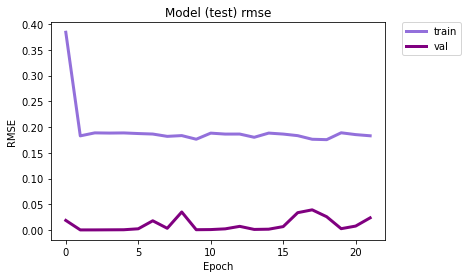

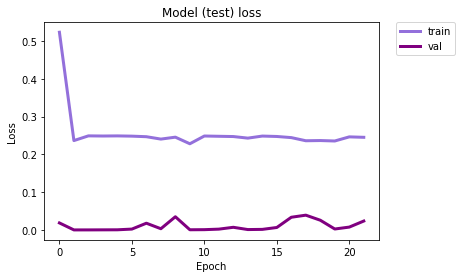

Epoch 1/300
5/5 [==============================] - 1s 165ms/step - loss: 0.1599 - mae: 0.0700 - rmse: 0.1763 - val_loss: 0.1389 - val_mae: 0.0616 - val_rmse: 0.1389
Epoch 2/300
5/5 [==============================] - 1s 177ms/step - loss: 0.1599 - mae: 0.0702 - rmse: 0.1763 - val_loss: 0.1389 - val_mae: 0.0616 - val_rmse: 0.1389
Epoch 3/300
5/5 [==============================] - 0s 108ms/step - loss: 0.1598 - mae: 0.0701 - rmse: 0.1763 - val_loss: 0.1389 - val_mae: 0.0615 - val_rmse: 0.1389
Epoch 4/300
5/5 [==============================] - 1s 149ms/step - loss: 0.1597 - mae: 0.0701 - rmse: 0.1762 - val_loss: 0.1389 - val_mae: 0.0615 - val_rmse: 0.1389
Epoch 5/300
5/5 [==============================] - 1s 122ms/step - loss: 0.1598 - mae: 0.0702 - rmse: 0.1763 - val_loss: 0.1388 - val_mae: 0.0614 - val_rmse: 0.1388
Epoch 6/300
5/5 [==============================] - 1s 137ms/step - loss: 0.1596 - mae: 0.0701 - rmse: 0.1760 - val_loss: 0.1387 - val_mae: 0.0612 - val_rmse: 0.1387
Epoch 7/30

Epoch 51/300
5/5 [==============================] - 0s 96ms/step - loss: 0.1563 - mae: 0.0782 - rmse: 0.1725 - val_loss: 0.1304 - val_mae: 0.0543 - val_rmse: 0.1304
Epoch 52/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1563 - mae: 0.0776 - rmse: 0.1717 - val_loss: 0.1307 - val_mae: 0.0537 - val_rmse: 0.1307
Epoch 53/300
5/5 [==============================] - 0s 91ms/step - loss: 0.1545 - mae: 0.0753 - rmse: 0.1705 - val_loss: 0.1303 - val_mae: 0.0547 - val_rmse: 0.1303
Epoch 54/300
5/5 [==============================] - 0s 92ms/step - loss: 0.1547 - mae: 0.0762 - rmse: 0.1688 - val_loss: 0.1297 - val_mae: 0.0560 - val_rmse: 0.1297
Epoch 55/300
5/5 [==============================] - 0s 95ms/step - loss: 0.1541 - mae: 0.0785 - rmse: 0.1677 - val_loss: 0.1292 - val_mae: 0.0575 - val_rmse: 0.1292
Epoch 56/300
5/5 [==============================] - 0s 88ms/step - loss: 0.1555 - mae: 0.0814 - rmse: 0.1694 - val_loss: 0.1292 - val_mae: 0.0573 - val_rmse: 0.1292
Epoch 57/3

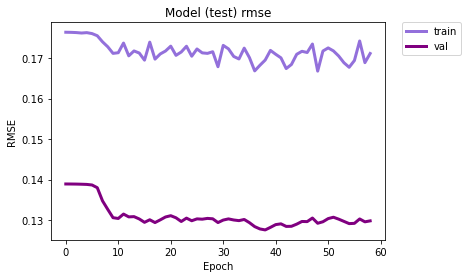

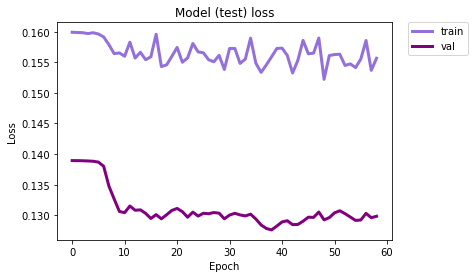

Epoch 1/300
7/7 [==============================] - 1s 96ms/step - loss: 0.1617 - mae: 0.0829 - rmse: 0.1485 - val_loss: 0.2535 - val_mae: 0.1144 - val_rmse: 0.1446
Epoch 2/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1632 - mae: 0.0764 - rmse: 0.1500 - val_loss: 0.2552 - val_mae: 0.1111 - val_rmse: 0.1407
Epoch 3/300
7/7 [==============================] - 1s 92ms/step - loss: 0.1648 - mae: 0.0727 - rmse: 0.1494 - val_loss: 0.2556 - val_mae: 0.1106 - val_rmse: 0.1399
Epoch 4/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1628 - mae: 0.0711 - rmse: 0.1491 - val_loss: 0.2556 - val_mae: 0.1106 - val_rmse: 0.1399
Epoch 5/300
7/7 [==============================] - 1s 93ms/step - loss: 0.1641 - mae: 0.0722 - rmse: 0.1492 - val_loss: 0.2560 - val_mae: 0.1103 - val_rmse: 0.1390
Epoch 6/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1624 - mae: 0.0714 - rmse: 0.1474 - val_loss: 0.2556 - val_mae: 0.1106 - val_rmse: 0.1398
Epoch 7/300
7/7 

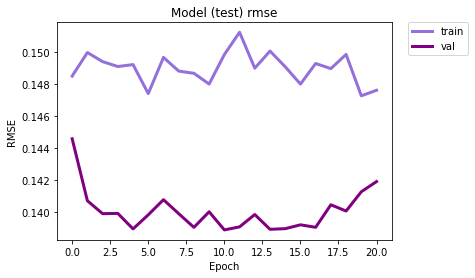

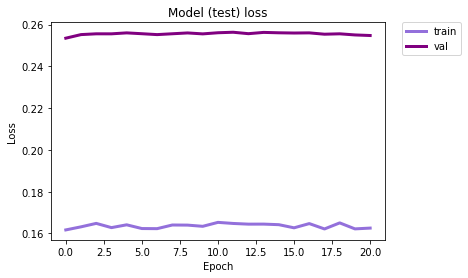

Epoch 1/300
9/9 [==============================] - 1s 98ms/step - loss: 0.1677 - mae: 0.0760 - rmse: 0.1578 - val_loss: 0.1744 - val_mae: 0.0573 - val_rmse: 0.1556
Epoch 2/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1658 - mae: 0.0792 - rmse: 0.1558 - val_loss: 0.1742 - val_mae: 0.0584 - val_rmse: 0.1554
Epoch 3/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1681 - mae: 0.0812 - rmse: 0.1592 - val_loss: 0.1748 - val_mae: 0.0557 - val_rmse: 0.1560
Epoch 4/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1678 - mae: 0.0775 - rmse: 0.1592 - val_loss: 0.1747 - val_mae: 0.0560 - val_rmse: 0.1559
Epoch 5/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1680 - mae: 0.0807 - rmse: 0.1591 - val_loss: 0.1749 - val_mae: 0.0555 - val_rmse: 0.1561
Epoch 6/300
9/9 [==============================] - 1s 87ms/step - loss: 0.1684 - mae: 0.0799 - rmse: 0.1595 - val_loss: 0.1754 - val_mae: 0.0539 - val_rmse: 0.1566
Epoch 7/300
9/9 

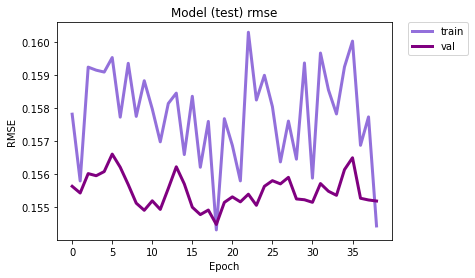

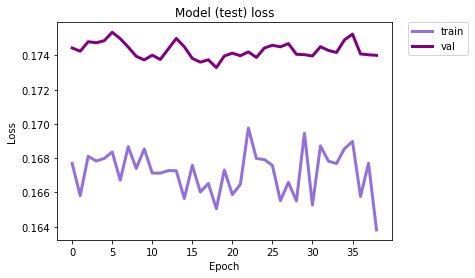

Epoch 1/300
11/11 [==============================] - 1s 93ms/step - loss: 0.1720 - mae: 0.0890 - rmse: 0.1766 - val_loss: 0.3367 - val_mae: 0.1731 - val_rmse: 0.3557
Epoch 2/300
11/11 [==============================] - 1s 95ms/step - loss: 0.1703 - mae: 0.0836 - rmse: 0.1753 - val_loss: 0.3349 - val_mae: 0.1767 - val_rmse: 0.3539
Epoch 3/300
11/11 [==============================] - 1s 103ms/step - loss: 0.1715 - mae: 0.0866 - rmse: 0.1766 - val_loss: 0.3376 - val_mae: 0.1716 - val_rmse: 0.3567
Epoch 4/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1724 - mae: 0.0836 - rmse: 0.1773 - val_loss: 0.3358 - val_mae: 0.1748 - val_rmse: 0.3548
Epoch 5/300
11/11 [==============================] - 1s 83ms/step - loss: 0.1741 - mae: 0.0864 - rmse: 0.1791 - val_loss: 0.3376 - val_mae: 0.1716 - val_rmse: 0.3567
Epoch 6/300
11/11 [==============================] - 1s 93ms/step - loss: 0.1739 - mae: 0.0852 - rmse: 0.1788 - val_loss: 0.3380 - val_mae: 0.1711 - val_rmse: 0.3571
Epo

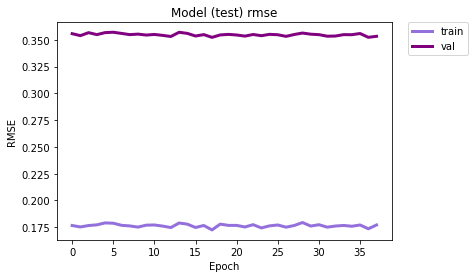

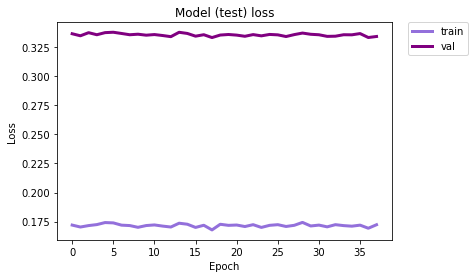

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9470851
Transformed yhat 14.581416
yhat -0.94762546
Transformed yhat 14.566869
yhat -0.9479425
Transformed yhat 14.558333
yhat -0.9481125
Transformed yhat 14.553757
yhat -0.94855773
Transformed yhat 14.54177
yhat -0.94855416
Transformed yhat 14.541866
yhat -0.948569
Transformed yhat 14.541467
yhat -0.9490846
Transformed yhat 14.527587
yhat -0.94977045
Transformed yhat 14.509122
yhat -0.9500315
Transformed yhat 14.502093
yhat -0.94973755
Transformed yhat 14.510008
yhat -0.9494637
Transformed yhat 14.51738
Real data: [14.53739625 13.78142822 13.28485923 20.90333904 13.56702515 14.64710752
 26.0210472  31.76332084 24.9508245  13.7534626  13.58656523 13.63227826
 13.91193444 13.15686275 13.15686275 13.15686275 13.15686275 13.15686275
 13.15686275 13.15686275 13.43651893 13.63227826 13.63227826 13.9979825 ]
Forecasting values: [14.6, 14.6, 14.6, 14.6, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5]


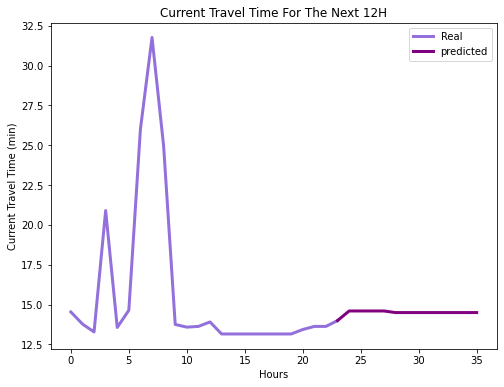

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)


In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.1',forecasts[i],hour[i]
        writer.writerow(d)
        

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 9s 840ms/step - loss: 0.6887 - mae: 0.6277 - rmse: 0.6184 - val_loss: 0.0197 - val_mae: 0.0197 - val_rmse: 0.0197
Epoch 2/300
3/3 [==============================] - 0s 112ms/step - loss: 0.4912 - mae: 0.2849 - rmse: 0.4385 - val_loss: 0.2635 - val_mae: 0.2635 - val_rmse: 0.2635
Epoch 3/300
3/3 [==============================] - 0s 87ms/step - loss: 0.4727 - mae: 0.3445 - rmse: 0.4292 - val_loss: 0.0018 - val_mae: 0.0018 - val_rmse: 0.0018
Epoch 4/300
3/3 [==============================] - 0s 104ms/step - loss: 0.5190 - mae: 0.2446 - rmse: 0.4671 - val_loss: 0.0048 - val_mae: 0.0048 - val_rmse: 0.0048
Epoch 5/300
3/3 [==============================] - 0s 106ms/step - loss: 0.5139 - mae: 0.2424 - rmse: 0.4601 - val_loss: 0.0589 - val_mae: 0.0589 - val_rmse: 0.0589
Epoch 6/300
3/3 [==============================] - 0s 100ms/step - loss: 0.4924 - mae: 0.3072 - rmse: 0.4392 - val_loss: 0.1401 - val_mae: 0.1401 - val_rmse: 0.1401
Epoch 7/300

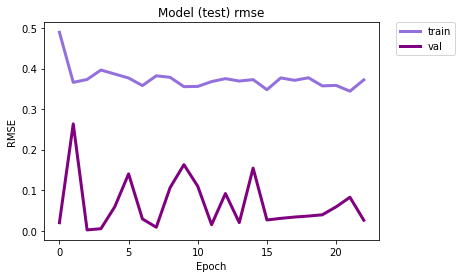

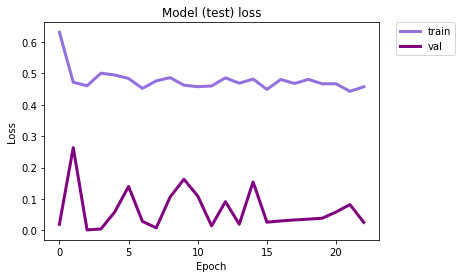

Epoch 1/300
5/5 [==============================] - 0s 104ms/step - loss: 0.3513 - mae: 0.1659 - rmse: 0.3969 - val_loss: 0.3668 - val_mae: 0.1671 - val_rmse: 0.3668
Epoch 2/300
5/5 [==============================] - 0s 79ms/step - loss: 0.3510 - mae: 0.1640 - rmse: 0.3964 - val_loss: 0.3661 - val_mae: 0.1660 - val_rmse: 0.3661
Epoch 3/300
5/5 [==============================] - 0s 81ms/step - loss: 0.3501 - mae: 0.1638 - rmse: 0.3954 - val_loss: 0.3648 - val_mae: 0.1636 - val_rmse: 0.3648
Epoch 4/300
5/5 [==============================] - 0s 79ms/step - loss: 0.3473 - mae: 0.1625 - rmse: 0.3929 - val_loss: 0.3617 - val_mae: 0.1578 - val_rmse: 0.3617
Epoch 5/300
5/5 [==============================] - 0s 86ms/step - loss: 0.3434 - mae: 0.1605 - rmse: 0.3888 - val_loss: 0.3545 - val_mae: 0.1444 - val_rmse: 0.3545
Epoch 6/300
5/5 [==============================] - 0s 89ms/step - loss: 0.3327 - mae: 0.1680 - rmse: 0.3764 - val_loss: 0.3432 - val_mae: 0.1540 - val_rmse: 0.3432
Epoch 7/300
5/5

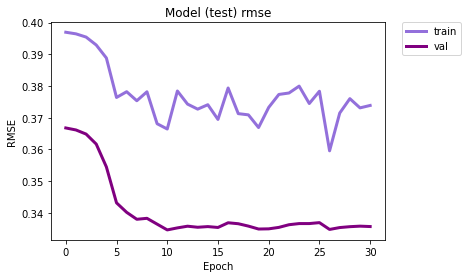

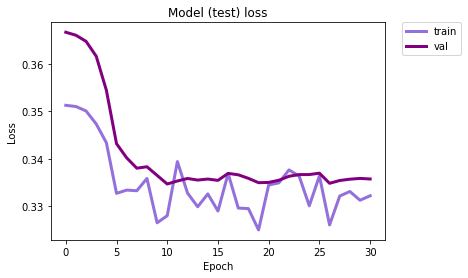

Epoch 1/300
7/7 [==============================] - 1s 88ms/step - loss: 0.3386 - mae: 0.2026 - rmse: 0.3137 - val_loss: 0.4988 - val_mae: 0.2771 - val_rmse: 0.3210
Epoch 2/300
7/7 [==============================] - 1s 141ms/step - loss: 0.3444 - mae: 0.1918 - rmse: 0.3175 - val_loss: 0.5012 - val_mae: 0.2721 - val_rmse: 0.3154
Epoch 3/300
7/7 [==============================] - 1s 117ms/step - loss: 0.3511 - mae: 0.1922 - rmse: 0.3196 - val_loss: 0.5035 - val_mae: 0.2674 - val_rmse: 0.3101
Epoch 4/300
7/7 [==============================] - 1s 137ms/step - loss: 0.3422 - mae: 0.1847 - rmse: 0.3126 - val_loss: 0.5039 - val_mae: 0.2664 - val_rmse: 0.3089
Epoch 5/300
7/7 [==============================] - 1s 147ms/step - loss: 0.3434 - mae: 0.1884 - rmse: 0.3149 - val_loss: 0.5046 - val_mae: 0.2650 - val_rmse: 0.3072
Epoch 6/300
7/7 [==============================] - 1s 121ms/step - loss: 0.3363 - mae: 0.1770 - rmse: 0.3074 - val_loss: 0.5034 - val_mae: 0.2672 - val_rmse: 0.3096
Epoch 7/300

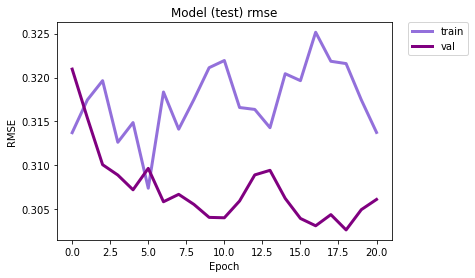

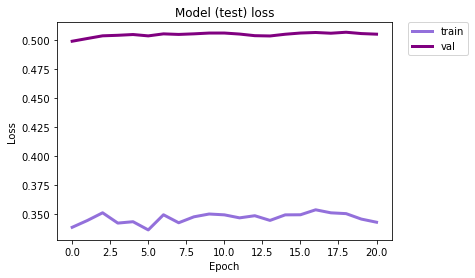

Epoch 1/300
9/9 [==============================] - 1s 87ms/step - loss: 0.3542 - mae: 0.1936 - rmse: 0.3385 - val_loss: 0.2591 - val_mae: 0.1256 - val_rmse: 0.2676
Epoch 2/300
9/9 [==============================] - 1s 75ms/step - loss: 0.3478 - mae: 0.1978 - rmse: 0.3316 - val_loss: 0.2594 - val_mae: 0.1389 - val_rmse: 0.2672
Epoch 3/300
9/9 [==============================] - 1s 81ms/step - loss: 0.3547 - mae: 0.2128 - rmse: 0.3407 - val_loss: 0.2592 - val_mae: 0.1242 - val_rmse: 0.2678
Epoch 4/300
9/9 [==============================] - 1s 76ms/step - loss: 0.3572 - mae: 0.2037 - rmse: 0.3424 - val_loss: 0.2590 - val_mae: 0.1266 - val_rmse: 0.2675
Epoch 5/300
9/9 [==============================] - 1s 78ms/step - loss: 0.3523 - mae: 0.2032 - rmse: 0.3358 - val_loss: 0.2591 - val_mae: 0.1340 - val_rmse: 0.2671
Epoch 6/300
9/9 [==============================] - 1s 82ms/step - loss: 0.3584 - mae: 0.2106 - rmse: 0.3421 - val_loss: 0.2590 - val_mae: 0.1284 - val_rmse: 0.2674
Epoch 7/300
9/9 

Epoch 51/300
9/9 [==============================] - 1s 83ms/step - loss: 0.3504 - mae: 0.2050 - rmse: 0.3341 - val_loss: 0.2589 - val_mae: 0.1355 - val_rmse: 0.2670
Epoch 52/300
9/9 [==============================] - 1s 75ms/step - loss: 0.3474 - mae: 0.2042 - rmse: 0.3305 - val_loss: 0.2589 - val_mae: 0.1359 - val_rmse: 0.2670
Epoch 53/300
9/9 [==============================] - 1s 92ms/step - loss: 0.3514 - mae: 0.2034 - rmse: 0.3350 - val_loss: 0.2591 - val_mae: 0.1384 - val_rmse: 0.2670
Epoch 54/300
9/9 [==============================] - 1s 86ms/step - loss: 0.3444 - mae: 0.2093 - rmse: 0.3300 - val_loss: 0.2587 - val_mae: 0.1319 - val_rmse: 0.2670
Epoch 55/300
9/9 [==============================] - 1s 84ms/step - loss: 0.3496 - mae: 0.2034 - rmse: 0.3332 - val_loss: 0.2589 - val_mae: 0.1360 - val_rmse: 0.2670
Epoch 56/300
9/9 [==============================] - 1s 91ms/step - loss: 0.3478 - mae: 0.2080 - rmse: 0.3319 - val_loss: 0.2588 - val_mae: 0.1349 - val_rmse: 0.2670
Epoch 57/3

9/9 [==============================] - 1s 89ms/step - loss: 0.3345 - mae: 0.1944 - rmse: 0.3188 - val_loss: 0.2594 - val_mae: 0.1433 - val_rmse: 0.2674
Epoch 101/300
9/9 [==============================] - 1s 86ms/step - loss: 0.3395 - mae: 0.2058 - rmse: 0.3273 - val_loss: 0.2586 - val_mae: 0.1350 - val_rmse: 0.2670
Epoch 102/300
9/9 [==============================] - 1s 84ms/step - loss: 0.3369 - mae: 0.1957 - rmse: 0.3217 - val_loss: 0.2587 - val_mae: 0.1370 - val_rmse: 0.2670
Epoch 103/300
9/9 [==============================] - 1s 87ms/step - loss: 0.3423 - mae: 0.2002 - rmse: 0.3258 - val_loss: 0.2589 - val_mae: 0.1395 - val_rmse: 0.2671
Epoch 104/300
9/9 [==============================] - 1s 94ms/step - loss: 0.3404 - mae: 0.2010 - rmse: 0.3261 - val_loss: 0.2591 - val_mae: 0.1406 - val_rmse: 0.2673
Epoch 105/300
9/9 [==============================] - 1s 90ms/step - loss: 0.3346 - mae: 0.1995 - rmse: 0.3198 - val_loss: 0.2595 - val_mae: 0.1439 - val_rmse: 0.2676
Epoch 106/300
9/9 

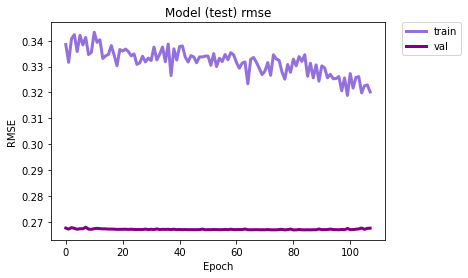

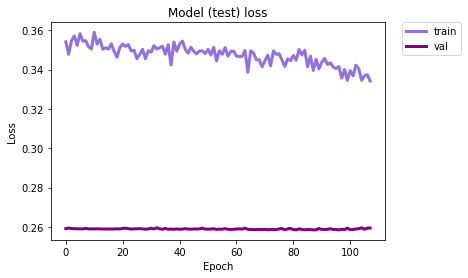

Epoch 1/300
11/11 [==============================] - 1s 96ms/step - loss: 0.3394 - mae: 0.1970 - rmse: 0.3526 - val_loss: 0.4968 - val_mae: 0.3025 - val_rmse: 0.5102
Epoch 2/300
11/11 [==============================] - 1s 87ms/step - loss: 0.3383 - mae: 0.1997 - rmse: 0.3479 - val_loss: 0.4923 - val_mae: 0.3089 - val_rmse: 0.5056
Epoch 3/300
11/11 [==============================] - 1s 88ms/step - loss: 0.3397 - mae: 0.2072 - rmse: 0.3501 - val_loss: 0.4920 - val_mae: 0.3079 - val_rmse: 0.5053
Epoch 4/300
11/11 [==============================] - 1s 86ms/step - loss: 0.3373 - mae: 0.2068 - rmse: 0.3487 - val_loss: 0.4916 - val_mae: 0.3074 - val_rmse: 0.5048
Epoch 5/300
11/11 [==============================] - 1s 99ms/step - loss: 0.3430 - mae: 0.2066 - rmse: 0.3542 - val_loss: 0.4917 - val_mae: 0.3059 - val_rmse: 0.5050
Epoch 6/300
11/11 [==============================] - 1s 88ms/step - loss: 0.3398 - mae: 0.2010 - rmse: 0.3502 - val_loss: 0.4893 - val_mae: 0.3082 - val_rmse: 0.5025
Epoc

11/11 [==============================] - 1s 84ms/step - loss: 0.3233 - mae: 0.1855 - rmse: 0.3308 - val_loss: 0.4468 - val_mae: 0.2723 - val_rmse: 0.4588
Epoch 51/300
11/11 [==============================] - 1s 92ms/step - loss: 0.3183 - mae: 0.1860 - rmse: 0.3283 - val_loss: 0.4467 - val_mae: 0.2705 - val_rmse: 0.4588
Epoch 52/300
11/11 [==============================] - 1s 83ms/step - loss: 0.3162 - mae: 0.1830 - rmse: 0.3247 - val_loss: 0.4374 - val_mae: 0.2798 - val_rmse: 0.4493
Epoch 53/300
11/11 [==============================] - 1s 87ms/step - loss: 0.3143 - mae: 0.1900 - rmse: 0.3215 - val_loss: 0.4401 - val_mae: 0.2713 - val_rmse: 0.4520
Epoch 54/300
11/11 [==============================] - 1s 86ms/step - loss: 0.3260 - mae: 0.1911 - rmse: 0.3362 - val_loss: 0.4439 - val_mae: 0.2664 - val_rmse: 0.4558
Epoch 55/300
11/11 [==============================] - 1s 85ms/step - loss: 0.3187 - mae: 0.1795 - rmse: 0.3277 - val_loss: 0.4353 - val_mae: 0.2751 - val_rmse: 0.4471
Epoch 56/30

11/11 [==============================] - 1s 82ms/step - loss: 0.2986 - mae: 0.1641 - rmse: 0.3020 - val_loss: 0.4025 - val_mae: 0.2445 - val_rmse: 0.4134
Epoch 100/300
11/11 [==============================] - 1s 82ms/step - loss: 0.2849 - mae: 0.1586 - rmse: 0.2883 - val_loss: 0.4107 - val_mae: 0.2246 - val_rmse: 0.4213
Epoch 101/300
11/11 [==============================] - 1s 79ms/step - loss: 0.2970 - mae: 0.1599 - rmse: 0.3002 - val_loss: 0.3942 - val_mae: 0.2426 - val_rmse: 0.4049
Epoch 102/300
11/11 [==============================] - 1s 81ms/step - loss: 0.3003 - mae: 0.1670 - rmse: 0.3055 - val_loss: 0.4039 - val_mae: 0.2293 - val_rmse: 0.4144
Epoch 103/300
11/11 [==============================] - 1s 95ms/step - loss: 0.2860 - mae: 0.1600 - rmse: 0.2853 - val_loss: 0.3905 - val_mae: 0.2327 - val_rmse: 0.4009
Epoch 104/300
11/11 [==============================] - 1s 87ms/step - loss: 0.3048 - mae: 0.1733 - rmse: 0.3187 - val_loss: 0.4073 - val_mae: 0.2258 - val_rmse: 0.4178
Epoch 

Epoch 148/300
11/11 [==============================] - 1s 64ms/step - loss: 0.2729 - mae: 0.1564 - rmse: 0.2710 - val_loss: 0.3794 - val_mae: 0.2150 - val_rmse: 0.3891
Epoch 149/300
11/11 [==============================] - 1s 53ms/step - loss: 0.2804 - mae: 0.1536 - rmse: 0.2874 - val_loss: 0.3793 - val_mae: 0.2121 - val_rmse: 0.3889
Epoch 150/300
11/11 [==============================] - 1s 53ms/step - loss: 0.2907 - mae: 0.1567 - rmse: 0.2967 - val_loss: 0.3835 - val_mae: 0.2334 - val_rmse: 0.3936
Epoch 151/300
11/11 [==============================] - 1s 55ms/step - loss: 0.2829 - mae: 0.1577 - rmse: 0.2910 - val_loss: 0.3843 - val_mae: 0.2245 - val_rmse: 0.3944
Epoch 152/300
11/11 [==============================] - 1s 51ms/step - loss: 0.2796 - mae: 0.1586 - rmse: 0.2889 - val_loss: 0.3841 - val_mae: 0.2129 - val_rmse: 0.3938
Epoch 153/300
11/11 [==============================] - 1s 59ms/step - loss: 0.2817 - mae: 0.1568 - rmse: 0.2862 - val_loss: 0.3826 - val_mae: 0.2094 - val_rmse:

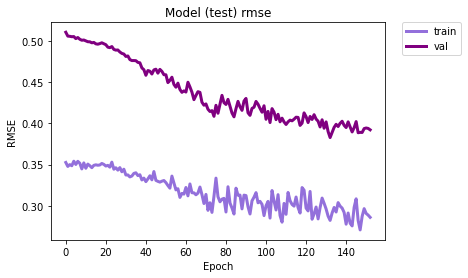

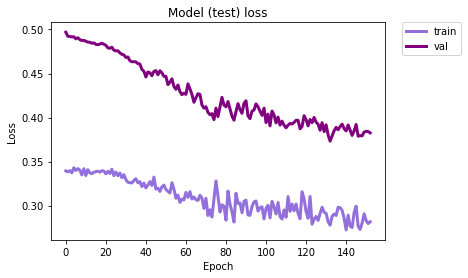

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.87024295
Transformed yhat 63.506733
yhat 0.86493224
Transformed yhat 63.363766
yhat 0.8707373
Transformed yhat 63.520046
yhat 0.88020974
Transformed yhat 63.77506
yhat 0.89121366
Transformed yhat 64.071304
yhat 0.89546096
Transformed yhat 64.185646
yhat 0.89616925
Transformed yhat 64.20471
yhat 0.8990475
Transformed yhat 64.282196
yhat 0.9039044
Transformed yhat 64.41296
yhat 0.9084205
Transformed yhat 64.53454
yhat 0.9082785
Transformed yhat 64.530716
yhat 0.9071442
Transformed yhat 64.500175
Real data: [61.94230769 64.35294118 66.57692308 50.84313725 65.11764706 61.82692308
 35.94117647 25.21568627 34.84615385 65.39215686 65.78846154 66.
 64.41176471 67.         67.         67.         67.         67.
 67.         67.         65.88235294 66.         66.         64.25641026]
Forecasting values: [63.5, 63.4, 63.5, 63.8, 64.1, 64.2, 64.2, 64.3, 64.4, 64.5, 64.5, 64.5]


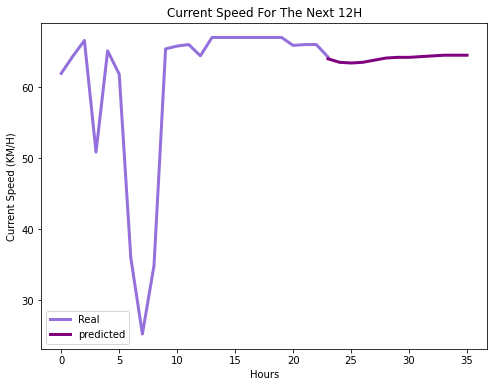

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.1',forecastSpeed[i],hour[i]
        writer.writerow(d)